# traditional-eval-first-attempt
1.30.23

Here I want to evaluate our five impute methods using some some traditional ML-style
eval criteria. 
Using a swarmplot for plotting. 
Integrating both MNAR and MCAR partitions -- can we plot these side-by-side?

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import time
import torch
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

# suppressing this CUDA initialization warning I always get
    # this could be dangerous
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# import my modules
sys.path.append('../../../../bin/')
from models.linear import GradNMFImputer
import util_functions
import intermediate_plots

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette()

#### Some configs

In [2]:
# MCAR partitioning params
val_frac = 0.3
test_frac = 0.0
min_present = 1

# MNAR partition params
q_anchor=0.3   
t_std=0.35
brnl_prob=0.4

# NMF model params
n_factors = 4              # 4 is default
tolerance = 0.0001         # 0.0001 is default
max_epochs = 1000          # 1000 is default
learning_rate = 0.01       # 0.01 is default
batch_size = 64            # 64 is default
loss_func = "MSE"

# kNN params
k_neighbors = 4

# the random number generator
rng = np.random.default_rng(seed=18)

# the random state for the partition
split_rand_state = 18

# The peptide quants matrices
full_path = \
    "/net/noble/vol2/home/lincolnh/code/"\
    "2021_ljharris_ms-impute/data/peptides-data/"
# pxds = ["PXD013792", "PXD014156", "PXD011961",
#         "PXD001010", "PXD014525", "PXD015939",
#         "PXD006109", "PXD006348",
#         "PXD019254", "PXD010612", "PXD010709",
#         "Pino2020", "Thomas2020", "PXD016079",
# ]
pxds = ["PXD013792", 
        "PXD014156", 
        "PXD006348", 
        "PXD011961"]

#### Define some functions

In [3]:
def mse_func(x_mat, y_mat):    
    """
    Get the mean square error (MSE) between two numpy
    arrays. The input arrays can have missing values.
    
    Parameters
    ----------
    x_mat, y_mat : np.ndarray, 
        The arrays, x and y, to calculate the MSE 
        between
        
    Returns
    ----------
    The MSE
    """
    x_rav = x_mat.ravel()
    y_rav = y_mat.ravel()
    missing = np.isnan(x_rav) | np.isnan(y_rav)
    mse = np.sum((x_rav[~missing] - y_rav[~missing])**2)

    if (np.sum(~missing) == 0):
        print("Warning: Computing MSE from all missing values.")
        return 0
    
    return mse / np.sum(~missing)


def nmf_impute(train_mat, val_mat):
    """
    Impute a peptide quants matrix with my NMF impute
    method. Transforms the validation set.
    
    Parameters
    ----------
    train_mat, val_mat : np.ndarray, 
        The training and validation matrices, respectively
    
    Returns
    ----------
    recon : np.ndarray, 
        The NMF reconstructed matrix
    """
    # get the optimal number of training batches for NMF
    if len(~np.isnan(train_mat)) > 100:
        n_batches = int(np.floor(len(~np.isnan(train_mat)) / batch_size))
        # setting the minimum n_batches to 100
        n_batches = max(n_batches, 100) 
    else: 
        n_batches = 1

    # init model 
    nmf_model = GradNMFImputer(
                    n_rows = train_mat.shape[0], 
                    n_cols = train_mat.shape[1], 
                    n_factors=n_factors, 
                    stopping_tol=tolerance,
                    train_batch_size=n_batches, 
                    eval_batch_size=n_batches,
                    n_epochs=max_epochs, 
                    loss_func=loss_func,
                    optimizer=torch.optim.Adam,
                    optimizer_kwargs={"lr": learning_rate},
                    non_negative=True,
                    rand_seed=rng.random(),
    )
    # fit and transform
    recon = nmf_model.fit_transform(train_mat, val_mat)
    
    return recon


def kNN_impute(train_mat):
    """
    Impute a peptide quants matrix with sklearn's
    kNN impute method
    
    Parameters
    ----------
    train_mat : np.ndarray,
        The training matrix
    
    Returns
    ----------
    k_recon : np.ndarray, 
        The kNN imputed matrix
    """
    knn_model = KNNImputer(n_neighbors=k_neighbors)
    k_recon = knn_model.fit_transform(train_mat)
    
    return k_recon


def sample_min_impute(train_mat):
    """
    Impute a peptide quants matrix with sample
    (column) min impute. 
    
    Parameters
    ----------
    train_mat : np.ndarray,
        The training matrix
    
    Returns
    ----------
    sm_recon : np.ndarray,
        The sample min reconstructed matrix
    """
    col_min = np.nanmin(train_mat, axis=0)
    nan_idx = np.where(np.isnan(train_mat))
    sm_recon = train_mat.copy()
    # nan_idx[1] -> take index of column
    sm_recon[nan_idx] = np.take(col_min, nan_idx[1])
    
    return sm_recon


def gaussian_sample_impute(train_mat):
    """
    Impute the peptide quants matrix with my 
    custom implementation of Gaussian sample 
    impute.
    
    Parameters
    ----------
    train_mat : np.ndarray, 
        The training matrix. 
    
    Returns
    ----------
    std_recon : np.ndarray,
        The Gaussian random sample reconstructed matrix. 
    """
    # get the column mins
    col_min = np.nanmin(train_mat, axis=0)

    # get the mean and std of the entire training matrix
    train_mean = np.nanmean(train_mat)
    train_sd = np.nanstd(train_mat)

    # get the indicies of the MVs 
    nan_idx = np.where(np.isnan(train_mat))
    std_recon = train_mat.copy()

    # how many total MVs? 
    n_mv = len(nan_idx[0])

    # fill in the MVs with random draws 
    std_recon[nan_idx] = rng.normal(
                                loc=np.mean(col_min), 
                                scale=np.std(col_min), 
                                size=n_mv
    )

    # don't want negative values
    std_recon = np.abs(std_recon)
    
    return std_recon

***

## The main loop -- MCAR partition

#### For each peptide quants dataset, impute with all five methods
And record each method's reconstruction error.

In [4]:
# init the reconstruction errors df
cols = ["pxd", "NMF MSE", "KNN MSE", 
        "Sample min MSE", "Gaussian sample MSE"]
recon_err_mcar = pd.DataFrame(columns=cols)

for pxd in pxds: 
    print(" ")
    print("working on: ", pxd)

    # pre-process the peptide quants df
    quants_raw = pd.read_csv(full_path + pxd + "_peptides.csv")

    # convert 0s to NaNs
    quants_raw[quants_raw == 0] = np.nan
    quants = np.array(quants_raw)
    
    # MCAR partition 
    train, val, test = util_functions.split(
                                    quants, 
                                    val_frac=val_frac,
                                    test_frac=test_frac, 
                                    min_present=min_present,
                                    random_state=split_rand_state,
    )
    
    # take a look at the MV fractions in the three sets
    orig_mv_frac = np.count_nonzero(np.isnan(quants)) / quants.size
    train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
    val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

    print("mv frac original: ", np.around(orig_mv_frac, decimals=3))
    print("mv frac train: ", np.around(train_mv_frac, decimals=3))
    print("mv frac validation: ", np.around(val_mv_frac, decimals=3))
    
    # impute with each method
    nmf_recon = nmf_impute(train, val)
    knn_recon = kNN_impute(train)
    smin_recon = sample_min_impute(train)
    gsample_recon = gaussian_sample_impute(train)
    # mf_recon = missForest_impute(train)
    
    # get reconstruction errors
    nmf_val_mse = mse_func(nmf_recon, val)
    knn_val_mse = mse_func(knn_recon, val)
    smin_val_mse = mse_func(smin_recon, val)
    gsample_val_mse = mse_func(gsample_recon, val)
    # mf_val_mse = mse_func(mf_recon, val)
    
    res = {
        "pxd" : pxd, 
        "NMF MSE" : nmf_val_mse,
        "KNN MSE" : knn_val_mse,
        "Sample min MSE" : smin_val_mse,
        "Gaussian sample MSE" : gsample_val_mse,
    }
    
    recon_err_mcar = recon_err_mcar.append(res, ignore_index=True)
    
print(" ")
print("done!")

 
working on:  PXD013792
mv frac original:  0.724
mv frac train:  0.778
mv frac validation:  0.921


  3%|▎         | 30/1000 [00:05<03:12,  5.04epoch/s]


early stopping triggered: wilcoxon criteria
 
working on:  PXD014156
mv frac original:  0.551
mv frac train:  0.657
mv frac validation:  0.855


  2%|▏         | 20/1000 [00:03<02:52,  5.68epoch/s]


early stopping triggered: wilcoxon criteria
 
working on:  PXD006348
mv frac original:  0.717
mv frac train:  0.781
mv frac validation:  0.911


  3%|▎         | 30/1000 [00:13<07:09,  2.26epoch/s]

early stopping triggered: wilcoxon criteria


 
working on:  PXD011961
mv frac original:  0.461
mv frac train:  0.612
mv frac validation:  0.834


  3%|▎         | 29/1000 [00:34<19:04,  1.18s/epoch]

early stopping triggered: standard criteria


 
done!


***

## Plotting

#### Massage the reconstruction errors dataframe

In [5]:
# switch up the column names
recon_err_mcar.columns = ["PXD", "NMF", "KNN", "Sample Min", "Gaussian Sample"]

# melt
recon_mcar_melted = recon_err_mcar.melt(id_vars="PXD")
recon_mcar_melted.columns = ["PXD", "Method", "MSE"]
# recon_mcar_melted

# get logged MSE
log_mse = np.log(recon_mcar_melted["MSE"])
recon_mcar_melted["Log MSE"] = log_mse

#### Swarmplot -- Method vs MSE

In [6]:
# plt.figure(figsize=(5,5))

# #sns.swarmplot(data=recon_mcar_melted, x="MSE", y="Method", hue="PXD", size=9.0)
# sns.swarmplot(data=recon_mcar_melted, x="Log MSE", y="Method", hue="PXD", size=9.0)

# plt.title("MCAR", pad=20)
# plt.legend(bbox_to_anchor=(1.0, 1.0))
# plt.xlabel("log Validation MSE", labelpad=10)
# plt.ylabel("", labelpad=10)

#### Swarmplot -- MSE vs Dataset

[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, ''), Text(3, 0, '')]

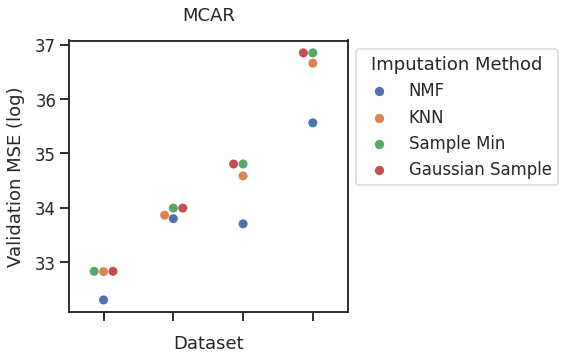

In [7]:
plt.figure(figsize=(5,5))

#fig = sns.swarmplot(data=recon_mcar_melted, x="PXD", y="MSE", hue="Method", size=9.0)
fig = sns.swarmplot(data=recon_mcar_melted, x="PXD", y="Log MSE", hue="Method", size=9.0)

plt.legend(bbox_to_anchor=(1.0, 1.0), title="Imputation Method")
plt.xlabel("Dataset", labelpad=10)
plt.ylabel("Validation MSE (log)", labelpad=10)
plt.title("MCAR", pad=20)

# hide the xtick labels
fig.xaxis.set_ticklabels([])

***

## Now lets do the same thing for MNAR partition 

In [8]:
# init the reconstruction errors df
cols = ["pxd", "NMF MSE", "KNN MSE", 
        "Sample min MSE", "Gaussian sample MSE"]
recon_err_mnar = pd.DataFrame(columns=cols)

for pxd in pxds: 
    print(" ")
    print("working on: ", pxd)

    # pre-process the peptide quants df
    quants_raw = pd.read_csv(full_path + pxd + "_peptides.csv")

    # convert 0s to NaNs
    quants_raw[quants_raw == 0] = np.nan
    quants = np.array(quants_raw)
    
    # MNAR partition 
    train, val = util_functions.MNAR_partition_thresholds_matrix(
                                        quants, 
                                        q_anchor=q_anchor, 
                                        t_std=t_std, 
                                        brnl_prob=brnl_prob, 
                                        min_pres=min_present,
                                        rand_state=split_rand_state,
    )
    
    # take a look at the MV fractions in the three sets
    orig_mv_frac = np.count_nonzero(np.isnan(quants)) / quants.size
    train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
    val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

    print("mv frac original: ", np.around(orig_mv_frac, decimals=3))
    print("mv frac train: ", np.around(train_mv_frac, decimals=3))
    print("mv frac validation: ", np.around(val_mv_frac, decimals=3))
    
    # impute with each method
    nmf_recon = nmf_impute(train, val)
    knn_recon = kNN_impute(train)
    smin_recon = sample_min_impute(train)
    gsample_recon = gaussian_sample_impute(train)
    # mf_recon = missForest_impute(train)
    
    # get reconstruction errors
    nmf_val_mse = mse_func(nmf_recon, val)
    knn_val_mse = mse_func(knn_recon, val)
    smin_val_mse = mse_func(smin_recon, val)
    gsample_val_mse = mse_func(gsample_recon, val)
    # mf_val_mse = mse_func(mf_recon, val) # todo: fix this
    
    res = {
        "pxd" : pxd, 
        "NMF MSE" : nmf_val_mse,
        "KNN MSE" : knn_val_mse,
        "Sample min MSE" : smin_val_mse,
        "Gaussian sample MSE" : gsample_val_mse,
    }
    
    recon_err_mnar = recon_err_mnar.append(res, ignore_index=True)
    
print(" ")
print("done!")

 
working on:  PXD013792
mv frac original:  0.724
mv frac train:  0.779
mv frac validation:  0.916


  2%|▏         | 20/1000 [00:03<02:57,  5.53epoch/s]


early stopping triggered: wilcoxon criteria
 
working on:  PXD014156
mv frac original:  0.551
mv frac train:  0.652
mv frac validation:  0.858


  3%|▎         | 29/1000 [00:04<02:37,  6.15epoch/s]


early stopping triggered: standard criteria
 
working on:  PXD006348
mv frac original:  0.717
mv frac train:  0.772
mv frac validation:  0.913


  3%|▎         | 29/1000 [00:12<07:09,  2.26epoch/s]

early stopping triggered: wilcoxon criteria


 
working on:  PXD011961
mv frac original:  0.461
mv frac train:  0.617
mv frac validation:  0.828


  2%|▎         | 25/1000 [00:29<18:55,  1.16s/epoch]

early stopping triggered: wilcoxon criteria


 
done!


#### Massage the recon errors dataframe

In [9]:
# switch up the column names
recon_err_mnar.columns = ["PXD", "NMF", "KNN", "Sample Min", "Gaussian Sample"]

# melt
recon_mnar_melted = recon_err_mnar.melt(id_vars="PXD")
recon_mnar_melted.columns = ["PXD", "Method", "MSE"]
# recon_mnar_melted

# get logged MSE
log_mse = np.log(recon_mnar_melted["MSE"])
recon_mnar_melted["Log MSE"] = log_mse

#### Plot

[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, ''), Text(3, 0, '')]

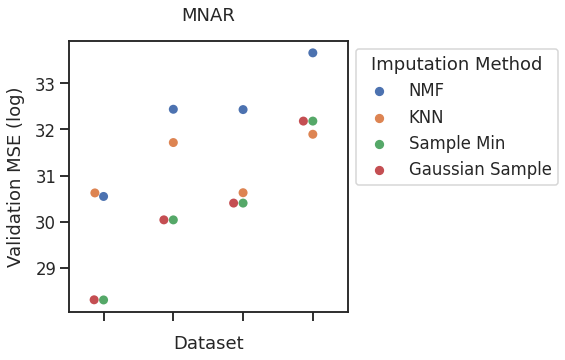

In [10]:
plt.figure(figsize=(5,5))

#fig = sns.swarmplot(data=recon_mcar_melted, x="PXD", y="MSE", hue="Method", size=9.0)
fig = sns.swarmplot(data=recon_mnar_melted, x="PXD", y="Log MSE", hue="Method", size=9.0)

plt.legend(bbox_to_anchor=(1.0, 1.0), title="Imputation Method")
plt.xlabel("Dataset", labelpad=10)
plt.ylabel("Validation MSE (log)", labelpad=10)
plt.title("MNAR", pad=20)

# hide the xtick labels
fig.xaxis.set_ticklabels([])

***

## Can we plot MCAR and MNAR side-by-side?

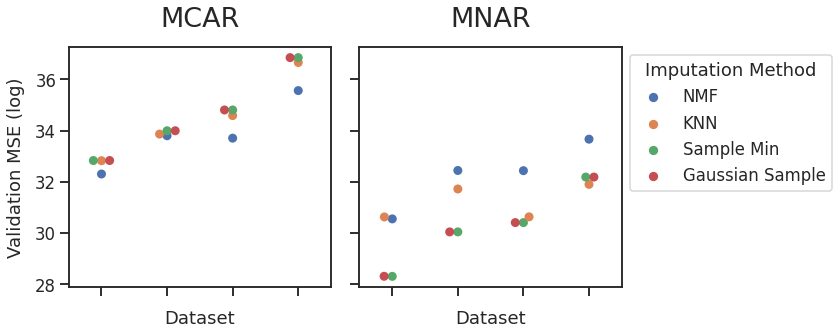

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,5))

sns.swarmplot(data=recon_mcar_melted, x="PXD", y="Log MSE", hue="Method", size=9.0, ax=axes[0])
axes[0].xaxis.set_ticklabels([])
axes[0].set_title("MCAR", pad=20, size=27)
axes[0].get_legend().remove()
axes[0].set_xlabel("Dataset", labelpad=10)
axes[0].set_ylabel("Validation MSE (log)", labelpad=10)

sns.swarmplot(data=recon_mnar_melted, x="PXD", y="Log MSE", hue="Method", size=9.0, ax=axes[1])
axes[1].xaxis.set_ticklabels([])
axes[1].set_title("MNAR", pad=20, size=27)
axes[1].legend(bbox_to_anchor=(1.0, 1.0), title="Imputation Method")
axes[1].set_xlabel("Dataset", labelpad=10)
axes[1].set_ylabel("", labelpad=10)

fig.tight_layout()
plt.savefig("swarm-mcar-and-mnar.png", dpi=250, bbox_inches="tight")

***

## Try a grouped barplot

#### For MCAR only

[[Text(0, 0, ''), Text(1, 0, ''), Text(2, 0, ''), Text(3, 0, '')]]

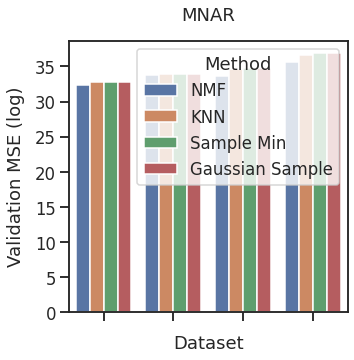

In [33]:
plt.figure(figsize=(5,5))

fig = sns.barplot(
    data=recon_mcar_melted,
    x="PXD",
    y="Log MSE",
    hue="Method"
)

#plt.legend(bbox_to_anchor=(1.0, 1.0), title="Imputation Method")
plt.xlabel("Dataset", labelpad=10)
plt.ylabel("Validation MSE (log)", labelpad=10)
plt.title("MNAR", pad=20)

fig.set(xticklabels=[])

#### For both MCAR and MNAR

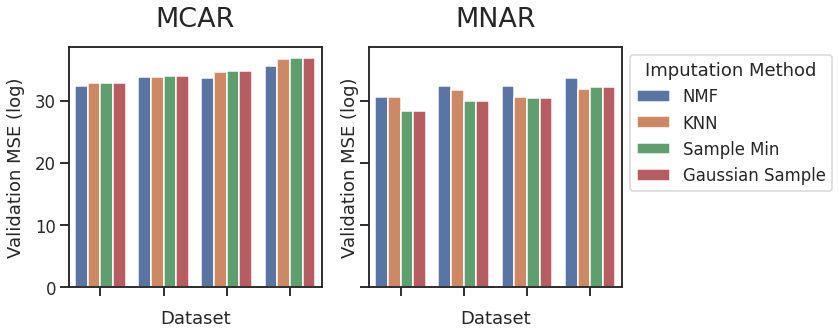

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,5))

sns.barplot(
    data=recon_mcar_melted,
    x="PXD",
    y="Log MSE",
    hue="Method",
    ax=axes[0]
)
axes[0].set_xlabel("Dataset", labelpad=10)
axes[0].set_ylabel("Validation MSE (log)", labelpad=10)
axes[0].set_title("MCAR", pad=20, size=27)
axes[0].set(xticklabels=[])
axes[0].get_legend().remove()

sns.barplot(
    data=recon_mnar_melted,
    x="PXD",
    y="Log MSE",
    hue="Method",
    ax=axes[1]
)
axes[1].set_xlabel("Dataset", labelpad=10)
axes[1].set_ylabel("Validation MSE (log)", labelpad=10)
axes[1].set_title("MNAR", pad=20, size=27)
axes[1].set(xticklabels=[])
axes[1].legend(bbox_to_anchor=(1.0, 1.0), title="Imputation Method")

fig.tight_layout()